# Data Exploration and Preparation for Thermal 3D Vision

## Dataset Structure Exploration

In [6]:
# dataset_exploration.py
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def explore_dataset(root_dir, dataset_name):
    """Explore the structure and statistics of a thermal dataset."""
    print(f"\n--- Exploring {dataset_name} Dataset at {root_dir} ---\n")
    
    # List all subdirectories
    subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    print(f"Subdirectories: {subdirs}")
    
    # Count image files by type
    img_extensions = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp']
    img_counts = defaultdict(int)
    img_resolutions = defaultdict(list)
    
    for ext in img_extensions:
        for filepath in glob.glob(os.path.join(root_dir, '**', f'*{ext}'), recursive=True):
            img_counts[ext] += 1
            
            # Sample some resolutions
            if img_counts[ext] <= 10:  # Just sample a few images
                try:
                    with Image.open(filepath) as img:
                        img_resolutions[ext].append(img.size)
                except Exception as e:
                    print(f"Error opening {filepath}: {e}")
    
    print("\nImage counts by extension:")
    for ext, count in img_counts.items():
        print(f"  {ext}: {count} files")
    
    print("\nSample image resolutions:")
    for ext, resolutions in img_resolutions.items():
        print(f"  {ext}: {resolutions}")
    
    # Try to identify RGB and thermal directories
    rgb_dirs = []
    thermal_dirs = []
    
    for subdir in subdirs:
        subdir_path = os.path.join(root_dir, subdir)
        # Look at filenames to guess content
        sample_files = glob.glob(os.path.join(subdir_path, '**', '*.*'), recursive=True)[:10]
        
        if any('rgb' in f.lower() or 'color' in f.lower() for f in sample_files):
            rgb_dirs.append(subdir)
        if any('thermal' in f.lower() or 'ir' in f.lower() or 'flir' in f.lower() for f in sample_files):
            thermal_dirs.append(subdir)
    
    print("\nPotential RGB directories:", rgb_dirs)
    print("Potential thermal directories:", thermal_dirs)
    
    return {
        'subdirs': subdirs,
        'img_counts': img_counts,
        'rgb_dirs': rgb_dirs, 
        'thermal_dirs': thermal_dirs
    }

# Run exploration
freiburg_info = explore_dataset('/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg', 'Freiburg Thermal')
flir_info = explore_dataset('/home/nfs/inf6/data/datasets/ThermalDBs/ADAS', 'FLIR ADAS')


--- Exploring Freiburg Thermal Dataset at /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg ---

Subdirectories: ['train', 'test']

Image counts by extension:
  .png: 54526 files
  .jpg: 64 files

Sample image resolutions:
  .png: [(1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650)]
  .jpg: [(1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650), (1920, 650)]

Potential RGB directories: ['test']
Potential thermal directories: ['train', 'test']

--- Exploring FLIR ADAS Dataset at /home/nfs/inf6/data/datasets/ThermalDBs/ADAS ---

Subdirectories: ['FLIR_ADAS_v2']

Image counts by extension:
  .jpg: 30788 files
  .tiff: 15635 files

Sample image resolutions:
  .jpg: [(640, 512), (640, 512), (640, 512), (640, 512), (640, 512), (640, 512), (640, 512), (640, 512), (640, 512), (640, 512)]
  .tiff: [(640, 512), (640, 512), (640, 512), (640, 512), (640, 512),

## Creating a Data Loading Module

In [1]:
# thermal_dataset.py
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2

class ThermalRGBPairDataset(Dataset):
    """Dataset for loading paired thermal and RGB images."""
    
    def __init__(self, rgb_dir, thermal_dir, transform=None, img_size=(224, 224), 
                 rgb_suffix='.png', thermal_suffix='.png', paired_by_name=True):
        """
        Args:
            rgb_dir: Directory containing RGB images
            thermal_dir: Directory containing thermal images
            transform: Optional transforms to apply
            img_size: Target image size
            rgb_suffix: File extension for RGB images
            thermal_suffix: File extension for thermal images
            paired_by_name: If True, pairs are matched by filename (minus suffix)
        """
        self.rgb_dir = rgb_dir
        self.thermal_dir = thermal_dir
        self.transform = transform
        self.img_size = img_size
        
        # Get all file paths
        self.rgb_files = sorted(glob.glob(os.path.join(rgb_dir, f'*{rgb_suffix}')))
        self.thermal_files = sorted(glob.glob(os.path.join(thermal_dir, f'*{thermal_suffix}')))
        
        # Match pairs by name
        if paired_by_name:
            self.pairs = []
            rgb_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in self.rgb_files}
            thermal_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in self.thermal_files}
            
            # Find common basenames
            common_names = set(rgb_basenames.keys()) & set(thermal_basenames.keys())
            self.pairs = [(rgb_basenames[name], thermal_basenames[name]) for name in common_names]
            print(f"Found {len(self.pairs)} matching RGB-thermal pairs")
        else:
            # Assume 1-to-1 correspondence by index
            min_len = min(len(self.rgb_files), len(self.thermal_files))
            self.pairs = [(self.rgb_files[i], self.thermal_files[i]) for i in range(min_len)]
            print(f"Paired {min_len} RGB-thermal images by index")
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        rgb_path, thermal_path = self.pairs[idx]
        
        # Load RGB image
        rgb_img = Image.open(rgb_path).convert('RGB')
        rgb_img = rgb_img.resize(self.img_size, Image.BILINEAR)
        rgb_img = np.array(rgb_img) / 255.0
        
        # Load thermal image - handling 16-bit if necessary
        thermal_img = cv2.imread(thermal_path, cv2.IMREAD_UNCHANGED)
        if thermal_img.dtype == np.uint16:
            thermal_img = (thermal_img.astype(np.float32) / 65535.0)
        else:
            thermal_img = thermal_img.astype(np.float32) / 255.0
            
        # If thermal is grayscale, convert to 3-channel
        if len(thermal_img.shape) == 2:
            thermal_img = np.stack([thermal_img] * 3, axis=-1)
        elif thermal_img.shape[2] == 1:
            thermal_img = np.concatenate([thermal_img] * 3, axis=-1)
            
        # Resize thermal image
        thermal_img = cv2.resize(thermal_img, self.img_size)
        
        # Apply transforms if available
        if self.transform:
            rgb_img = self.transform(rgb_img)
            thermal_img = self.transform(thermal_img)
        else:
            # Convert to PyTorch tensors (CxHxW)
            rgb_img = torch.from_numpy(rgb_img.transpose(2, 0, 1)).float()
            thermal_img = torch.from_numpy(thermal_img.transpose(2, 0, 1)).float()
        
        return {
            'rgb': rgb_img,
            'thermal': thermal_img,
            'rgb_path': rgb_path,
            'thermal_path': thermal_path
        }

def create_dataloaders(rgb_dir, thermal_dir, batch_size=8, img_size=(224, 224), 
                       split=0.8, rgb_suffix='.png', thermal_suffix='.png'):
    """Create training and validation dataloaders for thermal-RGB pairs."""
    
    dataset = ThermalRGBPairDataset(
        rgb_dir=rgb_dir,
        thermal_dir=thermal_dir,
        img_size=img_size,
        rgb_suffix=rgb_suffix,
        thermal_suffix=thermal_suffix
    )
    
    # Split into train and validation
    train_size = int(len(dataset) * split)
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_loader, val_loader

## Dataset-Specific Loaders

In [15]:
# dataset_loaders.py
import os


def load_freiburg_dataset(root_dir='/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg', 
                           batch_size=8, img_size=(224, 224)):
    """
    Load the Freiburg Thermal Dataset.
    
    The Freiburg dataset has:
    - 12051 daytime images
    - 8596 nighttime images
    - RGB and thermal images temporally aligned
    """
    # Based on dataset exploration, adjust these paths to match actual directory structure
    daytime_rgb_dir = os.path.join(root_dir, 'rgb', 'day')
    daytime_thermal_dir = os.path.join(root_dir, 'thermal', 'day')
    
    nighttime_rgb_dir = os.path.join(root_dir, 'rgb', 'night')
    nighttime_thermal_dir = os.path.join(root_dir, 'thermal', 'night')
    
    # Create dataloaders for daytime and nighttime separately
    daytime_train_loader, daytime_val_loader = create_dataloaders(
        daytime_rgb_dir, daytime_thermal_dir, batch_size, img_size
    )
    
    nighttime_train_loader, nighttime_val_loader = create_dataloaders(
        nighttime_rgb_dir, nighttime_thermal_dir, batch_size, img_size
    )
    
    return {
        'daytime': (daytime_train_loader, daytime_val_loader),
        'nighttime': (nighttime_train_loader, nighttime_val_loader)
    }

def load_flir_adas_dataset(root_dir='/home/nfs/inf6/data/datasets/ThermalDBs/ADAS', 
                           batch_size=8, img_size=(224, 224)):
    """
    Load the FLIR ADAS Dataset.
    
    The FLIR ADAS dataset has:
    - 9711 thermal images (unpaired)
    - 9233 RGB images (unpaired)
    - 7498 paired video frames
    """
    # Based on dataset exploration, adjust these paths to match actual directory structure
    # For paired data (assuming there's a directory with paired frames)
    paired_rgb_dir = os.path.join(root_dir, 'paired', 'rgb')
    paired_thermal_dir = os.path.join(root_dir, 'paired', 'thermal')
    
    # Create dataloaders for paired data
    paired_train_loader, paired_val_loader = create_dataloaders(
        paired_rgb_dir, paired_thermal_dir, batch_size, img_size
    )
    
    return {
        'paired': (paired_train_loader, paired_val_loader)
    }

In [16]:
# visualization.py
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def visualize_thermal_rgb_pair(rgb_img, thermal_img, figsize=(12, 6), colormap='inferno'):
    """
    Visualize a thermal-RGB image pair.
    
    Args:
        rgb_img: RGB image as numpy array (H,W,3) or PyTorch tensor (3,H,W)
        thermal_img: Thermal image as numpy array (H,W,3/1) or PyTorch tensor (3/1,H,W)
        figsize: Figure size
        colormap: Colormap to use for thermal image visualization
    """
    # Convert PyTorch tensors to numpy if needed
    if isinstance(rgb_img, torch.Tensor):
        rgb_img = rgb_img.permute(1, 2, 0).cpu().numpy()
    if isinstance(thermal_img, torch.Tensor):
        if thermal_img.shape[0] == 3:  # 3-channel
            thermal_img = thermal_img.permute(1, 2, 0).cpu().numpy()
        else:  # 1-channel
            thermal_img = thermal_img.squeeze(0).cpu().numpy()
    
    # If thermal is 3-channel but actually grayscale, convert to 1-channel
    if len(thermal_img.shape) == 3 and thermal_img.shape[2] == 3:
        if np.allclose(thermal_img[:,:,0], thermal_img[:,:,1]) and np.allclose(thermal_img[:,:,0], thermal_img[:,:,2]):
            thermal_img = thermal_img[:,:,0]
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot RGB image
    axes[0].imshow(np.clip(rgb_img, 0, 1))
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    # Plot thermal image with colormap
    if len(thermal_img.shape) == 3:  # If still 3-channel
        axes[1].imshow(np.clip(thermal_img, 0, 1))
    else:  # 1-channel grayscale
        thermal_display = axes[1].imshow(thermal_img, cmap=colormap)
        plt.colorbar(thermal_display, ax=axes[1], label='Thermal Intensity')
    axes[1].set_title('Thermal Image')
    axes[1].axis('off')
    
    plt.tight_layout()
    return fig

def visualize_batch(batch, num_samples=4, **kwargs):
    """Visualize multiple samples from a batch."""
    n = min(num_samples, len(batch['rgb']))
    
    for i in range(n):
        rgb = batch['rgb'][i]
        thermal = batch['thermal'][i]
        fig = visualize_thermal_rgb_pair(rgb, thermal, **kwargs)
        plt.show()

def enhance_thermal_contrast(thermal_img, clip_percentiles=(2, 98)):
    """Enhance contrast in thermal image by clipping and rescaling."""
    if isinstance(thermal_img, torch.Tensor):
        thermal_img = thermal_img.permute(1, 2, 0).cpu().numpy()
    
    # If 3-channel but actually grayscale
    if len(thermal_img.shape) == 3 and thermal_img.shape[2] == 3:
        if np.allclose(thermal_img[:,:,0], thermal_img[:,:,1]) and np.allclose(thermal_img[:,:,0], thermal_img[:,:,2]):
            thermal_img = thermal_img[:,:,0]
    
    # Compute percentiles and clip
    low = np.percentile(thermal_img, clip_percentiles[0])
    high = np.percentile(thermal_img, clip_percentiles[1])
    
    # Clip and rescale to [0, 1]
    enhanced = np.clip(thermal_img, low, high)
    enhanced = (enhanced - low) / (high - low)
    
    return enhanced

In [17]:
# explore_thermal_datasets.py
import os
import numpy as np
import matplotlib.pyplot as plt
# from thermal_dataset import ThermalRGBPairDataset
# from visualization import visualize_thermal_rgb_pair, enhance_thermal_contrast

def main():
    # Set paths based on your actual structure after exploring the datasets
    freiburg_root = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg'
    flir_root = '/home/nfs/inf6/data/datasets/ThermalDBs/ADAS'
    
    # Example paths - replace with actual paths from your exploration
    freiburg_rgb_dir = os.path.join(freiburg_root, 'rgb', 'day')  # Example path
    freiburg_thermal_dir = os.path.join(freiburg_root, 'thermal', 'day')  # Example path
    
    flir_rgb_dir = os.path.join(flir_root, 'paired', 'rgb')  # Example path
    flir_thermal_dir = os.path.join(flir_root, 'paired', 'thermal')  # Example path
    
    # Create datasets
    freiburg_dataset = ThermalRGBPairDataset(
        rgb_dir=freiburg_rgb_dir,
        thermal_dir=freiburg_thermal_dir,
        img_size=(224, 224)
    )
    
    flir_dataset = ThermalRGBPairDataset(
        rgb_dir=flir_rgb_dir,
        thermal_dir=flir_thermal_dir,
        img_size=(224, 224)
    )
    
    # Visualize some samples from each dataset
    print("Visualizing Freiburg Thermal Dataset samples:")
    for i in range(5):  # Visualize 5 samples
        sample = freiburg_dataset[i]
        rgb = sample['rgb']
        thermal = sample['thermal']
        
        # Enhance thermal contrast for better visualization
        enhanced_thermal = enhance_thermal_contrast(thermal)
        
        # Visualize
        fig = visualize_thermal_rgb_pair(rgb, enhanced_thermal)
        plt.title(f"Freiburg Sample {i}")
        plt.savefig(f"freiburg_sample_{i}.png")
        plt.show()
    
    print("\nVisualizing FLIR ADAS Dataset samples:")
    for i in range(5):  # Visualize 5 samples
        sample = flir_dataset[i]
        rgb = sample['rgb']
        thermal = sample['thermal']
        
        # Enhance thermal contrast for better visualization
        enhanced_thermal = enhance_thermal_contrast(thermal)
        
        # Visualize
        fig = visualize_thermal_rgb_pair(rgb, enhanced_thermal)
        plt.title(f"FLIR ADAS Sample {i}")
        plt.savefig(f"flir_sample_{i}.png")
        plt.show()

if __name__ == "__main__":
    main()

Found 0 matching RGB-thermal pairs
Found 0 matching RGB-thermal pairs
Visualizing Freiburg Thermal Dataset samples:


IndexError: list index out of range

In [18]:
# freiburg_visualizer.py
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

def find_drive_folders(base_path):
    """Find all drive folders in the Freiburg dataset."""
    train_dir = os.path.join(base_path, 'train')
    sequences = sorted(os.listdir(train_dir))
    
    all_drive_folders = []
    for seq in sequences:
        seq_path = os.path.join(train_dir, seq)
        # Get numbered subfolders (drives)
        subfolders = [f for f in os.listdir(seq_path) if os.path.isdir(os.path.join(seq_path, f))]
        for subfolder in subfolders:
            drive_path = os.path.join(seq_path, subfolder)
            all_drive_folders.append((seq, subfolder, drive_path))
    
    return all_drive_folders

def load_images_from_drive(drive_path):
    """Load RGB and IR images from a drive folder."""
    # Find all image files in the drive folder
    rgb_files = sorted(glob.glob(os.path.join(drive_path, '*rgb*.png')))
    ir_files = sorted(glob.glob(os.path.join(drive_path, '*ir*.png')))
    
    if not rgb_files and not ir_files:
        # Try looking for specific file patterns if the above fails
        rgb_files = sorted(glob.glob(os.path.join(drive_path, '*color*.png')))
        ir_files = sorted(glob.glob(os.path.join(drive_path, '*thermal*.png')))
    
    # If still no files, try searching recursively
    if not rgb_files and not ir_files:
        rgb_files = sorted(glob.glob(os.path.join(drive_path, '**/*rgb*.png'), recursive=True))
        ir_files = sorted(glob.glob(os.path.join(drive_path, '**/*ir*.png'), recursive=True))
    
    return rgb_files, ir_files

def visualize_ir(ir_img, min_val=21800, max_val=23700):
    """Visualize IR image with colormap."""
    # If the image is a file path, load it
    if isinstance(ir_img, str):
        ir_img = cv2.imread(ir_img, cv2.IMREAD_ANYDEPTH)
    
    # Convert to float32 for processing
    ir_img = ir_img.astype(np.float32)
    
    # Apply thresholding
    ir_img[ir_img < min_val] = min_val
    ir_img[ir_img > max_val] = max_val
    
    # Normalize to 0-1
    ir_img = (ir_img - min_val) / (max_val - min_val)
    
    # Apply colormap
    ir_img_color = cv2.applyColorMap((ir_img * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    return ir_img_color

def visualize_rgb(rgb_img):
    """Visualize RGB image."""
    # If the image is a file path, load it
    if isinstance(rgb_img, str):
        rgb_img = cv2.imread(rgb_img)
        # Convert from BGR to RGB
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
    
    return rgb_img

def overlay_thermal_rgb(rgb_img, ir_img, alpha=0.4):
    """Overlay thermal image on RGB image."""
    # Make sure both images are of the same size
    if rgb_img.shape[:2] != ir_img.shape[:2]:
        ir_img = cv2.resize(ir_img, (rgb_img.shape[1], rgb_img.shape[0]))
    
    # Overlay images
    beta = 1.0 - alpha
    overlay = cv2.addWeighted(rgb_img, alpha, ir_img, beta, 0.0)
    
    return overlay

def visualize_dataset(dataset_path, num_samples=5):
    """Visualize samples from the Freiburg dataset."""
    drive_folders = find_drive_folders(dataset_path)
    
    if not drive_folders:
        print(f"No drive folders found in {dataset_path}")
        return
    
    print(f"Found {len(drive_folders)} drive folders")
    
    # Create output directory
    os.makedirs('freiburg_samples', exist_ok=True)
    
    # Sample from different sequences if possible
    sampled_sequences = set()
    sample_count = 0
    
    for seq, subfolder, drive_path in drive_folders:
        # Skip if we've already sampled from this sequence
        if sample_count >= num_samples and seq in sampled_sequences:
            continue
        
        sampled_sequences.add(seq)
        
        print(f"\nProcessing {seq}/{subfolder}...")
        rgb_files, ir_files = load_images_from_drive(drive_path)
        
        print(f"Found {len(rgb_files)} RGB images and {len(ir_files)} IR images")
        
        # If no images found, continue to next drive
        if not rgb_files or not ir_files:
            continue
        
        # If number of RGB and IR images differ, take the minimum
        num_files = min(len(rgb_files), len(ir_files))
        
        # Sample a few images from this drive
        for i in range(min(3, num_files)):
            if sample_count >= num_samples:
                break
                
            rgb_path = rgb_files[i]
            ir_path = ir_files[i]
            
            # Load and visualize images
            rgb_img = visualize_rgb(rgb_path)
            ir_img = visualize_ir(ir_path)
            overlay = overlay_thermal_rgb(rgb_img, ir_img)
            
            # Create figure for visualization
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Plot RGB image
            axes[0].imshow(rgb_img)
            axes[0].set_title(f'RGB Image - {seq}/{subfolder}')
            axes[0].axis('off')
            
            # Plot IR image
            axes[1].imshow(cv2.cvtColor(ir_img, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Thermal Image - {seq}/{subfolder}')
            axes[1].axis('off')
            
            # Plot overlay
            axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            axes[2].set_title(f'Overlay - {seq}/{subfolder}')
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.savefig(f'freiburg_samples/{seq}_{subfolder}_sample_{i}.png')
            plt.close()
            
            sample_count += 1
            
    print(f"\nSaved {sample_count} samples to freiburg_samples/ directory")

if __name__ == "__main__":
    dataset_path = "/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg"
    visualize_dataset(dataset_path, num_samples=10)

Found 49 drive folders

Processing seq_00_day/02...
Found 1000 RGB images and 500 IR images

Processing seq_00_day/01...
Found 954 RGB images and 477 IR images

Processing seq_00_day/03...
Found 910 RGB images and 910 IR images

Processing seq_00_day/04...
Found 268 RGB images and 134 IR images

Processing seq_00_night/01...
Found 501 RGB images and 501 IR images

Processing seq_01_day/04...
Found 834 RGB images and 417 IR images

Processing seq_01_night/00...
Found 496 RGB images and 496 IR images

Processing seq_02_day/01...
Found 1004 RGB images and 502 IR images

Processing seq_02_night/00...
Found 495 RGB images and 495 IR images

Processing seq_03_day/04...
Found 1004 RGB images and 502 IR images

Processing seq_04_day/00...
Found 998 RGB images and 499 IR images

Saved 10 samples to freiburg_samples/ directory


## Generating Pseudo-GT 

In [2]:
import os
import numpy as np
import torch
import cv2
from tqdm import tqdm
import argparse
from pathlib import Path
import sys
import matplotlib.pyplot as plt

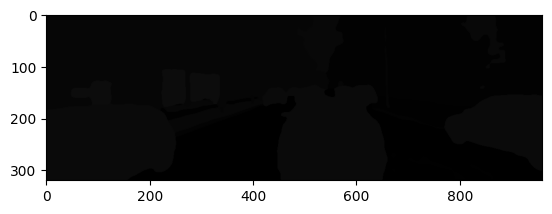

In [12]:
import cv2
import matplotlib.pyplot as plt

img_path = "/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb_labels/fl_rgb_labels_1570722744_6518346560.png"
rgb = cv2.imread(img_path)
if rgb is None:
    print(f"Failed to load image from {img_path}")
else:
    plt.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
    plt.show()


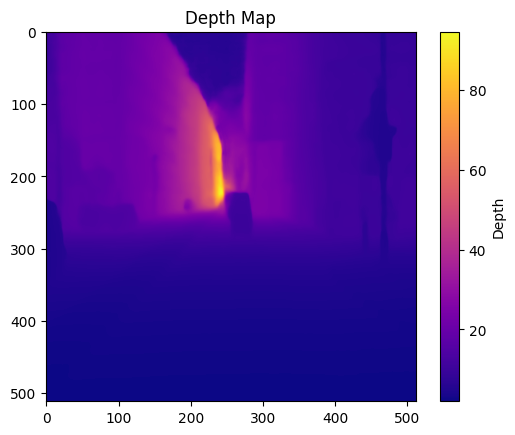

Intrinsics:
 [[-376.37235243    0.          256.        ]
 [   0.         -380.46995109  256.        ]
 [   0.            0.            1.        ]]
Pose:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


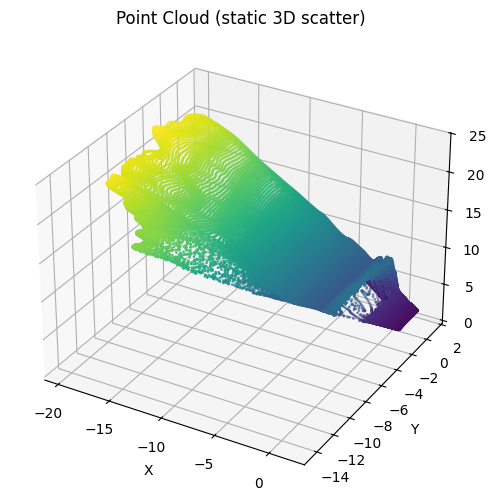

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

depth = np.load("pseudo_gt/depth/fl_rgb_1578921057_2341029900.npy")
plt.imshow(depth, cmap="plasma")
plt.colorbar(label="Depth")
plt.title("Depth Map")
plt.show()

intrinsics = np.load("pseudo_gt/intrinsics/fl_rgb_1578921057_2341029900.npy")
print("Intrinsics:\n", intrinsics)

pose = np.load("pseudo_gt/poses/fl_rgb_1578919257_6643455820.npy")
print("Pose:\n", pose)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

pointmap_path = "pseudo_gt/pointmaps/fl_rgb_1570722156_952177040.npy"
pmap = np.load(pointmap_path)  # shape [H, W, 3]

# Flatten to [N,3]
points = pmap.reshape(-1, 3)

# Filter invalid points if needed
valid = np.isfinite(points).all(axis=1) & (points[:,2] > 0)
points = points[valid]
depths = points[:,2]
colors = cm.viridis((depths - depths.min()) / (depths.max() - depths.min()))
# Plot with matplotlib
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
# ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
ax.scatter(points[:,0], points[:,1], points[:,2], s=1, c=colors)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Point Cloud (static 3D scatter)")
plt.show()




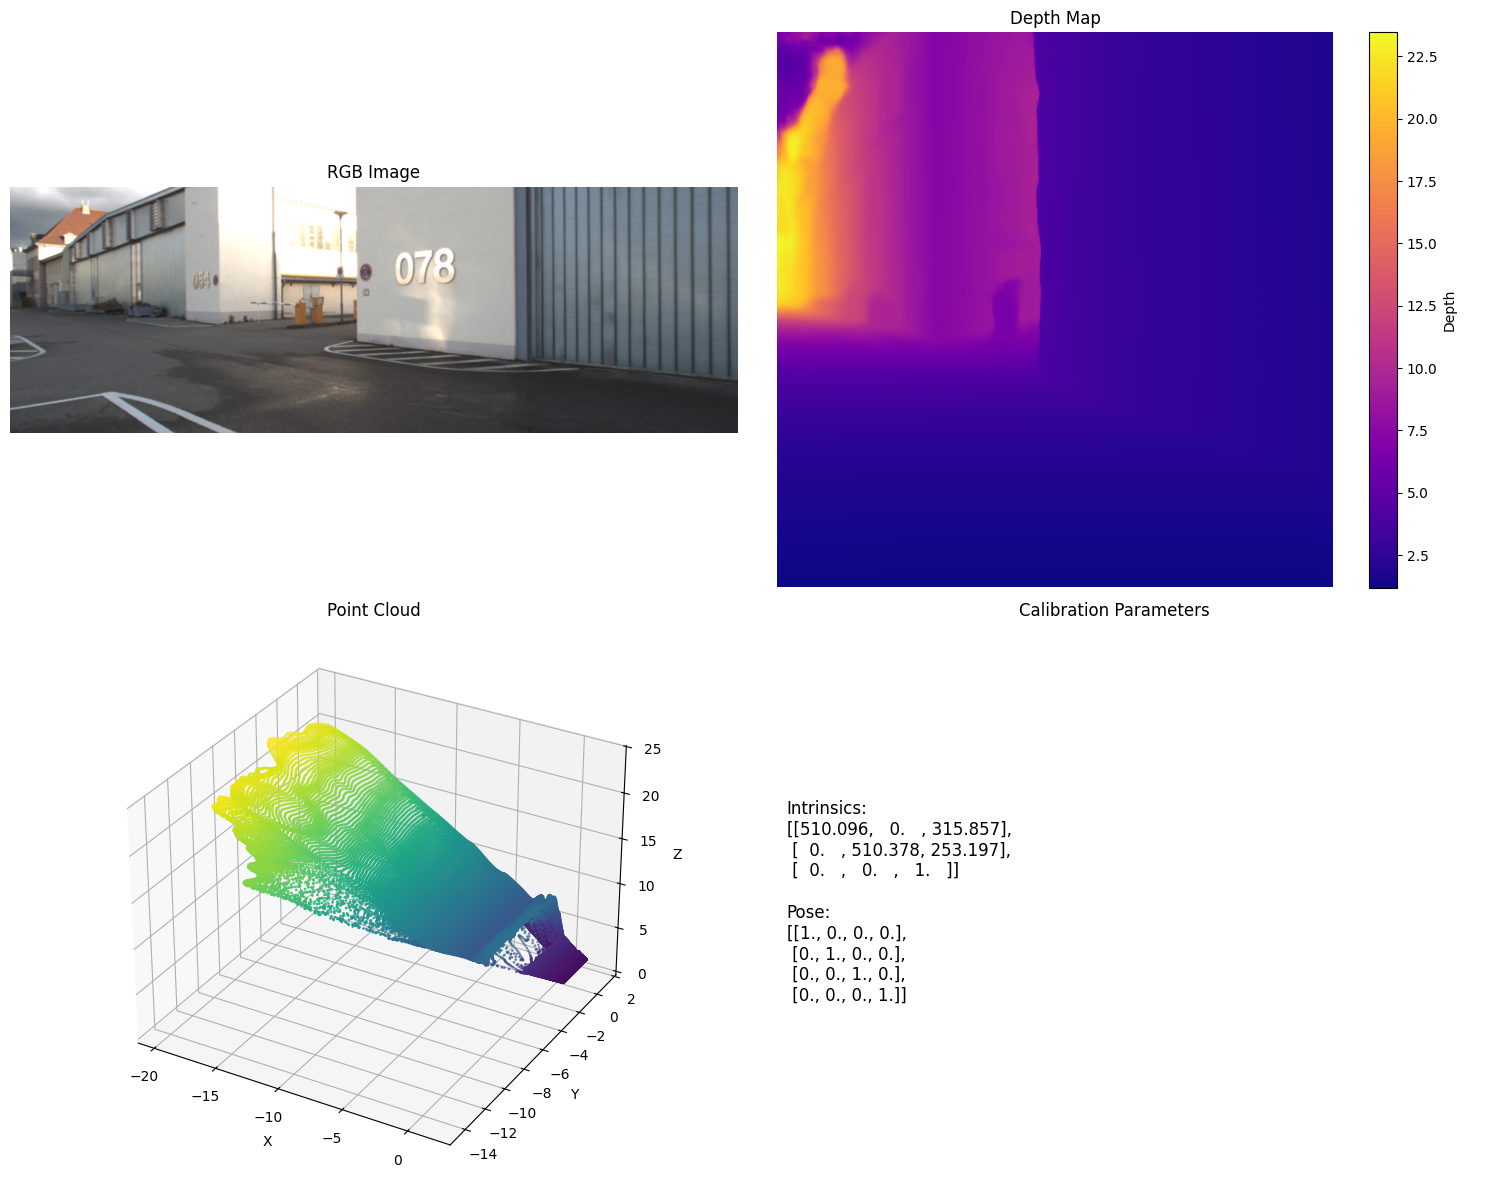

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# --- Helper function for 3D scatter ---
def plot_point_cloud(ax, pointmap_path, point_size=1):
    # Load full 3D pointmap (shape: [H, W, 3])
    pmap = np.load(pointmap_path)
    points = pmap.reshape(-1, 3)
    # Filter valid points (for instance, only keep those with positive z)
    valid = np.isfinite(points).all(axis=1) & (points[:, 2] > 0)
    points = points[valid]
    # Color points by depth
    depths = points[:, 2]
    colors = cm.viridis((depths - depths.min()) / (depths.max() - depths.min()))
    
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=point_size, c=colors)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Point Cloud")

# --- Main visualization function ---
def visualize_sample(rgb_path, depth_path, intrinsics_path, pose_path, pointmap_path):
    # Load RGB image (using cv2)
    rgb = cv2.imread(rgb_path)
    if rgb is None:
        raise ValueError(f"RGB image not found: {rgb_path}")
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    
    # Load depth map (.npy) and scale if needed (we assume depth is already in a displayable range)
    depth = np.load(depth_path)
    
    # Load intrinsics and pose (print them as text)
    intrinsics = np.load(intrinsics_path)
    pose = np.load(pose_path)
    
    # Create a 2x2 subplot
    fig = plt.figure(figsize=(15, 12))
    
    # Top left: RGB image
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.imshow(rgb)
    ax1.set_title("RGB Image")
    ax1.axis("off")
    
    # Top right: Depth map
    ax2 = fig.add_subplot(2, 2, 2)
    im2 = ax2.imshow(depth, cmap="plasma")
    ax2.set_title("Depth Map")
    fig.colorbar(im2, ax=ax2, label="Depth")
    ax2.axis("off")
    
    # Bottom left: 3D point cloud
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    plot_point_cloud(ax3, pointmap_path, point_size=1)
    
    # Bottom right: Text info (intrinsics and pose)
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.axis("off")
    text_str = "Intrinsics:\n" + np.array2string(intrinsics, precision=3, separator=", ") + "\n\nPose:\n" + np.array2string(pose, precision=3, separator=", ")
    ax4.text(0.05, 0.5, text_str, fontsize=12, va='center', ha='left', transform=ax4.transAxes)
    ax4.set_title("Calibration Parameters")
    
    plt.tight_layout()
    plt.show()

# --- Example usage ---
# Adjust these paths to one sample from your pseudo_gt folder:
rgb_sample_path = "/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722156_952177040.png"  # RGB visualization saved earlier
depth_sample_path = "pseudo_gt/depth/fl_rgb_1570722156_952177040.npy"
intrinsics_sample_path = "pseudo_gt/intrinsics/fl_rgb_1570722156_952177040.npy"
pose_sample_path = "pseudo_gt/poses/fl_rgb_1570722156_952177040.npy"  # example pose file
pointmap_sample_path = "pseudo_gt/pointmaps/fl_rgb_1570722156_952177040.npy"

visualize_sample(rgb_sample_path, depth_sample_path, intrinsics_sample_path, pose_sample_path, pointmap_sample_path)


In [27]:
# /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_ir_aligned/

import cv2
import matplotlib.pyplot as plt

img_path = "/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_ir_aligned/fl_rgb_labels_1570722582_9885497920.png"
rgb = cv2.imread(img_path)
# if rgb is None:
    # print(f"Failed to load image from {img_path}")
# else:
plt.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
plt.show()

[ WARN:0@65304.827] global loadsave.cpp:241 findDecoder imread_('/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_ir_aligned/fl_rgb_labels_1570722582_9885497920.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
